Processing volkswagen tiguan: 100%|██████████| 147/147 [00:00<00:00, 640.63it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Accuracy: 0.3868
Confusion Matrix:
[[ 2  0  0  0  1  2  0  0  0  4  0  0  0  0  0  1  0  0  0  0]
 [ 0  4  1  0  1  1  1  1  0  0  0  0  1  2  2  0  0  0  1  0]
 [ 0  1 14  2  4  0  0  0  0  0  0  0  1  1  1  2  1  0  1  0]
 [ 0  0  0 32  9  3  0  0  0  6  2  0  0  2  0  3  2  0  1  2]
 [ 0  0  0  2 19  1  0  0  0  3  0  0  1  1  1  3  1  0  0  1]
 [ 1  1  1  6  3  5  0  0  0  6  1  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  4  1  1  8  0  0  0  0  0  0  2  0  0  0  0  0  1]
 [ 0  0  0  1  2  0  1  7  0  2  0  1  1  0  1  0  0  1  6  0]
 [ 0  0  0  0  1  0  0  0 11  0  0  0  0  0  1  2  0  0  0  0]
 [ 0  2  2  9  6  5  0  0  0 20  2  0  1  1  2  3  2  0  0  1]
 [ 0  0  1  3  3  0  0  0  1  0  2  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  1  0  0  1  0  2  0  1  0  1  0  3  1  0]
 [ 1  1  2  3  3  0  0  0  0  2  0  0  5  1  2  0  1  1  1  2]
 [ 0  1  0  6  1  1  2  1  0  2  0  0  0 11  1  1  0  0  1  0]
 [ 0  0  2  2  5  0  1  0  0  0  0  1  0  1  6  0  0  0  0  2]
 [ 0  

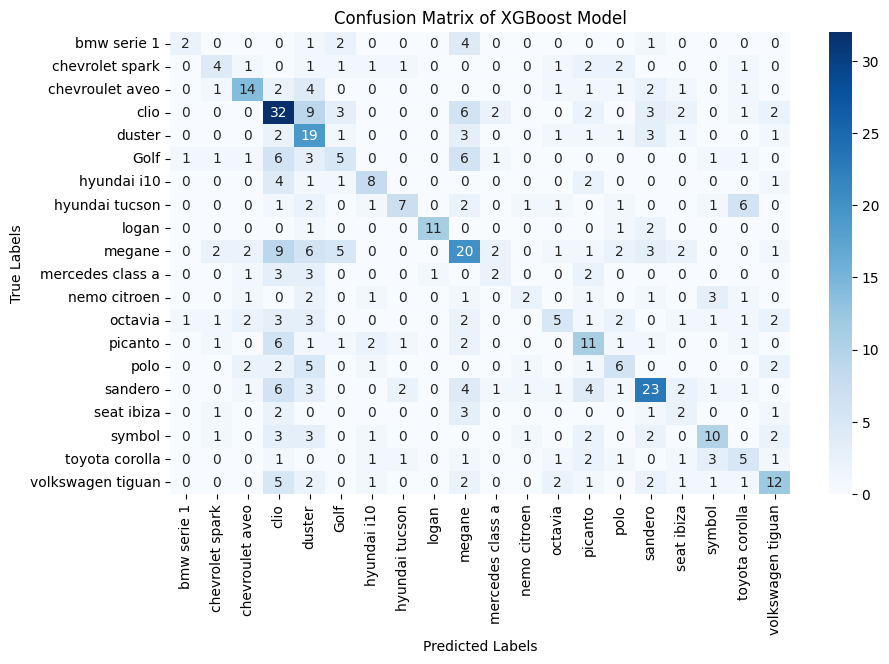

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
data_dir = "dataset/datasetsplitted/train"

# Check if dataset directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError("Dataset directory not found. Please verify the path.")

# Function to extract HSV histogram features
def extract_hsv_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Collect descriptors and labels
image_features = []
labels = []
image_paths = []

# Read images, extract HSV features, and assign labels
label_map = {}
label_counter = 0
for car_model in os.listdir(data_dir):
    model_path = os.path.join(data_dir, car_model)
    if os.path.isdir(model_path):
        if car_model not in label_map:
            label_map[car_model] = label_counter
            label_counter += 1
        for img_name in tqdm(os.listdir(model_path), desc=f"Processing {car_model}"):
            img_path = os.path.join(model_path, img_name)
            features = extract_hsv_features(img_path)
            if features is not None:
                image_features.append(features)
                labels.append(label_map[car_model])
                image_paths.append(img_path)

# Convert to numpy arrays
X = np.array(image_features)
y = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_map.keys())

print(f"XGBoost Model Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of XGBoost Model")
plt.show()
